## Simple Exponential Smoothing (SES)

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

### Dữ liệu ghi nhận doanh số xe bán ra hàng tháng ở Na Uy theo hãng từ năm 2007 đến 2017, dưới dạng chuỗi thời gian (time series).

In [ ]:

df = pd.read_csv("/content/norway_new_car_sales_by_make.csv")
df["ds"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str) + "-1")
df = df[["ds", "Make", "Pct","Quantity"]]
df.head()

,ds,Make,Pct,Quantity
0,2007-01-01,Toyota,22.7,2884
1,2007-01-01,Volkswagen,19.9,2521
2,2007-01-01,Peugeot,8.1,1029
3,2007-01-01,Ford,6.9,870
4,2007-01-01,Volvo,5.5,693


In [111]:
df.ds.tail()

,ds
4372,2017-01-01
4373,2017-01-01
4374,2017-01-01
4375,2017-01-01
4376,2017-01-01


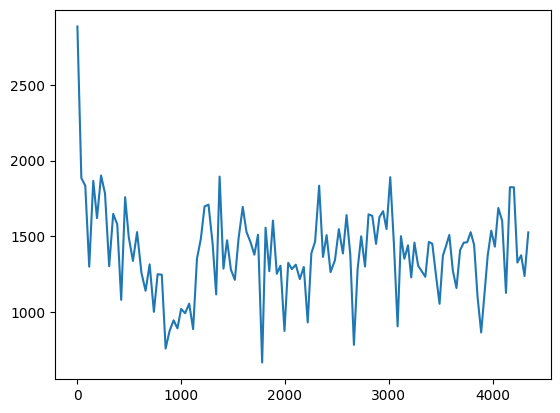

In [ ]:
plt.plot(df.query("Make == 'Toyota'").Quantity)

In [ ]:
train = df.query("Make == 'Toyota'")[["ds", "Quantity"]]
test = df.query("Make == 'Toyota' & ds >= '2015-01-01'")[["ds", "Quantity"]]

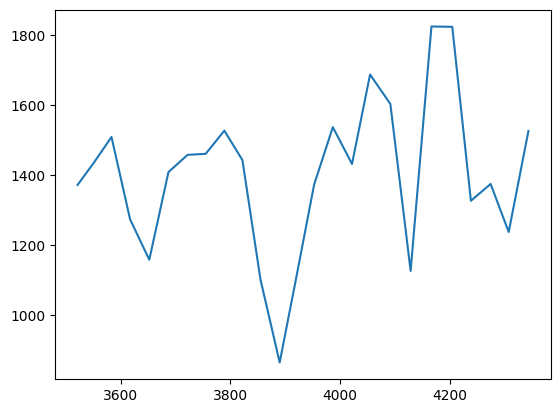

In [ ]:
plt.plot(test)

In [83]:
# Loại bỏ log
import warnings
from statsmodels.tools.sm_exceptions import EstimationWarning

# Tắt cảnh báo EstimationWarning
warnings.filterwarnings("ignore", category=EstimationWarning)

## Kiểm tra lần nữa với hãng xe Volkswagen

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


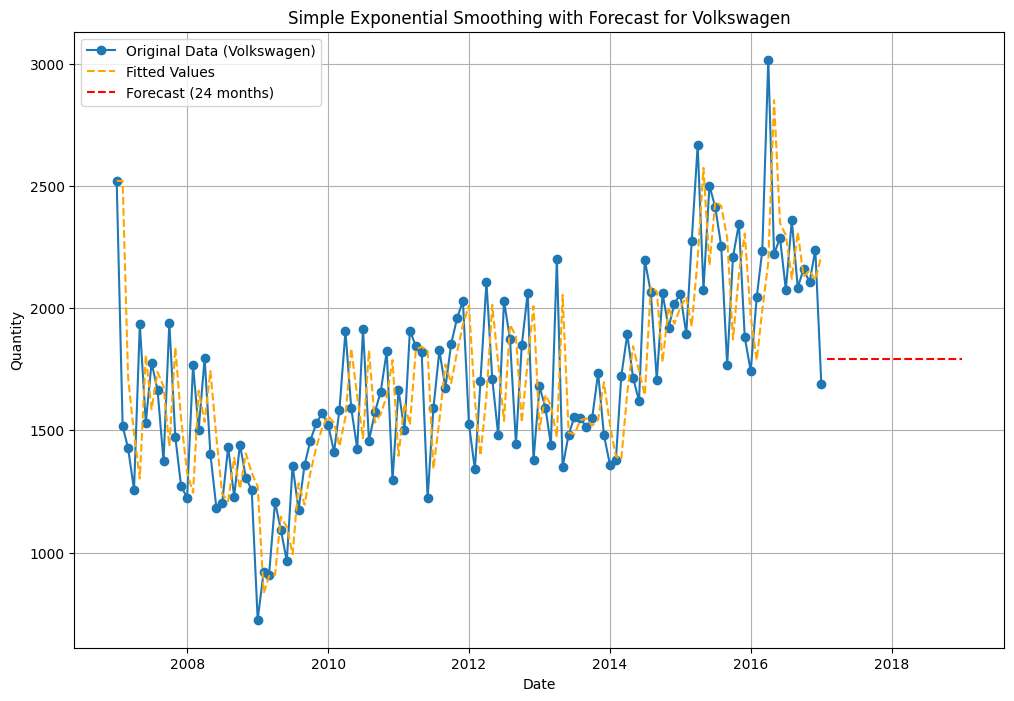

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Lọc dữ liệu cho Volkswagen
vw_data = df.query("Make == 'Volkswagen'").copy()
vw_data["ds"] = pd.to_datetime(vw_data["ds"])  # Đảm bảo cột ds là datetime
vw_data.set_index("ds", inplace=True)

# Fit the model
model = SimpleExpSmoothing(vw_data["Quantity"])
model_fit = model.fit(smoothing_level=0.8, optimized=False)  # optimized=False để tránh cảnh báo

# Lấy fitted values
vw_data["Fitted"] = model_fit.fittedvalues

# Dự báo thêm 24 tháng (2 năm)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

# Tạo chỉ số thời gian cho forecast
last_date = vw_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq="MS")
forecast_df = pd.DataFrame({"Forecast": forecast}, index=forecast_index)

# Plot dữ liệu gốc, fitted values, và forecast
plt.figure(figsize=(12, 8))
plt.plot(vw_data.index, vw_data["Quantity"], label="Original Data (Volkswagen)", marker="o")
plt.plot(vw_data.index, vw_data["Fitted"], label="Fitted Values", linestyle="--", color="orange")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast (24 months)", linestyle="--", color="red")
plt.title("Simple Exponential Smoothing with Forecast for Volkswagen")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


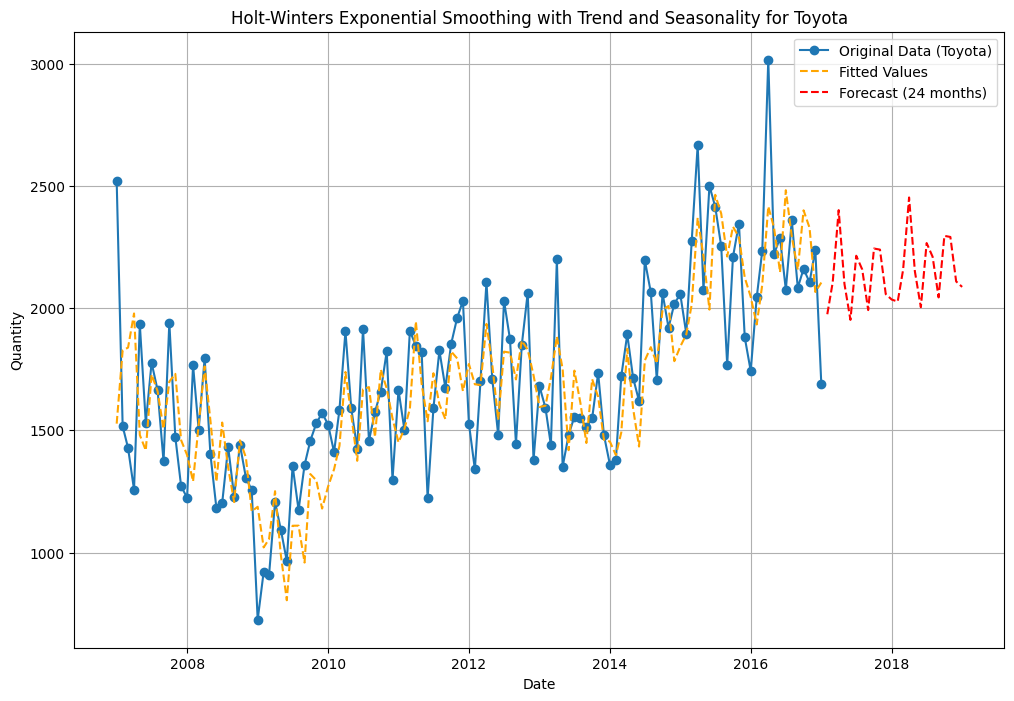

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Lọc dữ liệu cho Toyota
toyota_data = df.query("Make == 'Volkswagen'").copy()
toyota_data["ds"] = pd.to_datetime(toyota_data["ds"])  # Đảm bảo cột ds là datetime
toyota_data.set_index("ds", inplace=True)

# Fit the model with trend and seasonality
model = ExponentialSmoothing(
    toyota_data["Quantity"],
    trend="add",  # Hoặc "mul" nếu dữ liệu có xu hướng nhân
    seasonal="add",  # Hoặc "mul" nếu dữ liệu có yếu tố mùa vụ nhân
    seasonal_periods=12,  # Chu kỳ mùa vụ (12 tháng)
)
model_fit = model.fit(optimized=True)

# Lấy fitted values
toyota_data["Fitted"] = model_fit.fittedvalues

# Dự báo thêm 24 tháng (2 năm)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

# Tạo chỉ số thời gian cho forecast
last_date = toyota_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq="MS")
forecast_df = pd.DataFrame({"Forecast": forecast}, index=forecast_index)

# Plot dữ liệu gốc, fitted values, và forecast
plt.figure(figsize=(12, 8))
plt.plot(toyota_data.index, toyota_data["Quantity"], label="Original Data (Toyota)", marker="o")
plt.plot(toyota_data.index, toyota_data["Fitted"], label="Fitted Values", linestyle="--", color="orange")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast (24 months)", linestyle="--", color="red")
plt.title("Holt-Winters Exponential Smoothing with Trend and Seasonality for Toyota")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid()
plt.show()


In [302]:
# Lọc dữ liệu cho Volkswagen
volkswagen_data = df.query("Make == 'Volkswagen'")[["ds", "Make", "Quantity"]].copy()
volkswagen_data["ds"] = pd.to_datetime(volkswagen_data["ds"])  # Chuyển đổi cột ds về dạng datetime

# Xác định tập test: 3 tháng cuối cùng
test = volkswagen_data[volkswagen_data["ds"] >= volkswagen_data["ds"].max() - pd.DateOffset(months=6)]

# Tạo tập train 1: 3 tháng gần nhất trước tập test
train_1 = volkswagen_data[
    (volkswagen_data["ds"] < test["ds"].min()) &
    (volkswagen_data["ds"] >= test["ds"].min() - pd.DateOffset(months=4))
]

# Tạo tập train 2: Toàn bộ dữ liệu trừ 3 tháng cuối
train_2 = volkswagen_data[volkswagen_data["ds"] < test["ds"].min()][50:]

# Kiểm tra kết quả
print("Test Data:")
print(test)

print("\nTrain 1 (Last 3 months before test):")
print(train_1)

print("\nTrain 2 (All except last 3 months):")
print(train_2)


Test Data:
             ds        Make  Quantity
4128 2016-07-01  Volkswagen      2076
4166 2016-08-01  Volkswagen      2359
4204 2016-09-01  Volkswagen      2084
4238 2016-10-01  Volkswagen      2161
4273 2016-11-01  Volkswagen      2106
4307 2016-12-01  Volkswagen      2239
4342 2017-01-01  Volkswagen      1688

Train 1 (Last 3 months before test):
             ds        Make  Quantity
3986 2016-03-01  Volkswagen      2236
4021 2016-04-01  Volkswagen      3017
4054 2016-05-01  Volkswagen      2222
4091 2016-06-01  Volkswagen      2287

Train 2 (All except last 3 months):
             ds        Make  Quantity
1883 2011-03-01  Volkswagen      1908
1920 2011-04-01  Volkswagen      1845
1956 2011-05-01  Volkswagen      1822
1993 2011-06-01  Volkswagen      1222
2030 2011-07-01  Volkswagen      1590
...         ...         ...       ...
3952 2016-02-01  Volkswagen      2044
3986 2016-03-01  Volkswagen      2236
4021 2016-04-01  Volkswagen      3017
4054 2016-05-01  Volkswagen      2222
40

## Ngắn hạn

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


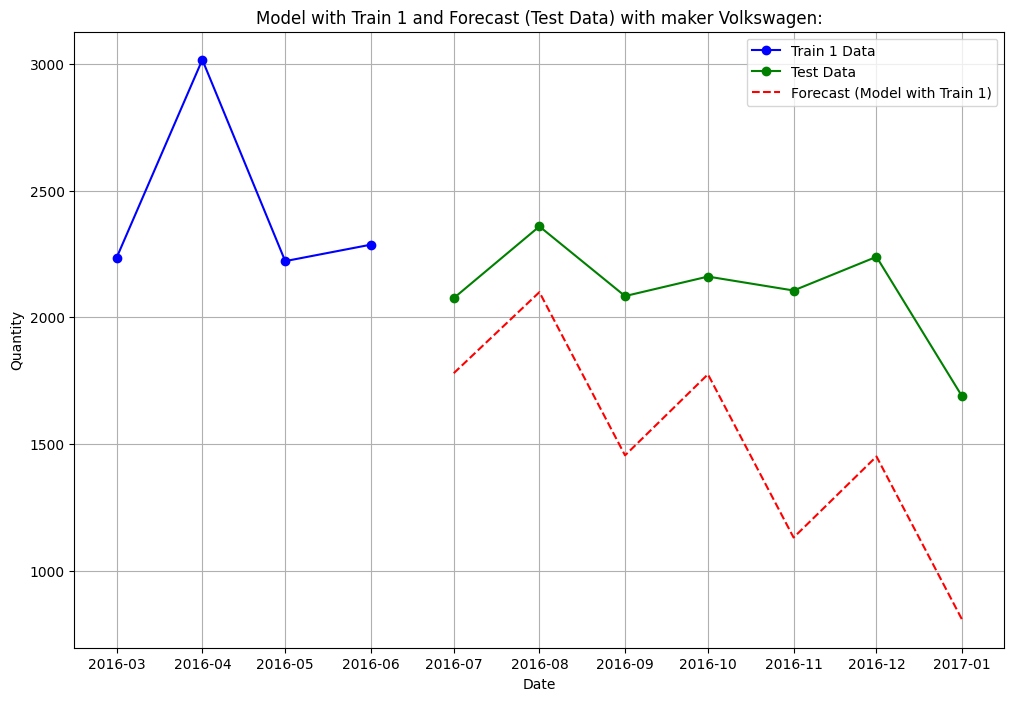

Forecast for Model (Train 1 with Test) with maker Volkswagen:
4     1779.578507
5     2099.557174
6     1455.199706
7     1775.178372
8     1130.820904
9     1450.799571
10     806.442103
dtype: float64
MAPE: 29.58%


In [303]:
# Xây dựng mô hình Exponential Smoothing với trend và seasonality
model = ExponentialSmoothing(
    train_1["Quantity"],
    trend="add",  # Áp dụng yếu tố trend
    seasonal="add",  # Áp dụng yếu tố seasonality
    seasonal_periods=2  # Số mùa vụ (12 tháng trong 1 năm)
)

# Huấn luyện mô hình
model_fit = model.fit()

# Dự báo cho 3 tháng (test)
forecast = model_fit.forecast(steps=7)

# Vẽ kết quả cho mô hình
plt.figure(figsize=(12, 8))

# Plot dữ liệu gốc và dự báo
plt.plot(train_1["ds"], train_1["Quantity"], label="Train 1 Data", color="blue", marker="o")
plt.plot(test["ds"], test["Quantity"], label="Test Data", color="green", marker="o")
plt.plot(test["ds"], forecast[:], label="Forecast (Model with Train 1)", color="red", linestyle="--")
plt.title("Model with Train 1 and Forecast (Test Data) with maker Volkswagen:")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid()

plt.show()

# In ra kết quả dự báo
print("Forecast for Model (Train 1 with Test) with maker Volkswagen:")
print(forecast)
# Dự báo (forecast)
forecast_val = forecast.values

# Giá trị thực tế (Actual)
actual_val = test["Quantity"].values

# Tính MAPE
mape = np.mean(np.abs((actual_val - forecast_val) / actual_val)) * 100
# In ra kết quả MAPE
print(f"MAPE: {mape:.2f}%")

## Dài hạn


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


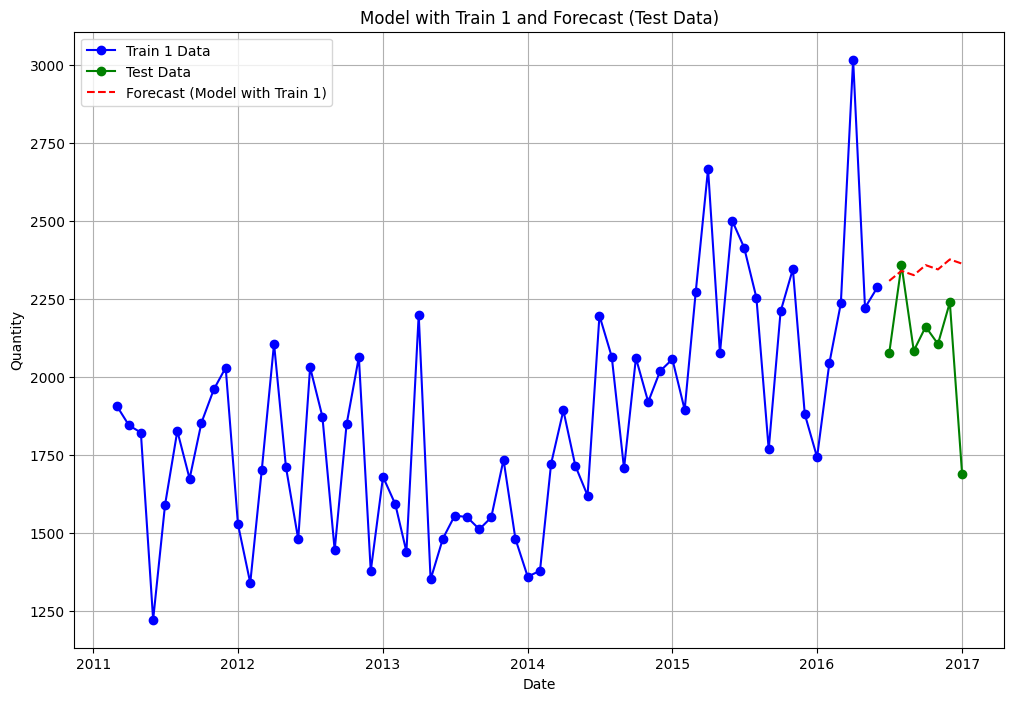

Forecast for Model (Train 1 with Test):
64    2308.139979
65    2340.192424
66    2326.498395
67    2358.550840
68    2344.856811
69    2376.909256
70    2363.215227
dtype: float64
MAPE: 12.89%


In [305]:
# Xây dựng mô hình Exponential Smoothing với trend và seasonality
model = ExponentialSmoothing(
    train_2["Quantity"],
    trend="add",  # Áp dụng yếu tố trend
    seasonal="add",  # Áp dụng yếu tố seasonality
    seasonal_periods= 2  # Số mùa vụ (12 tháng trong 1 năm)
)

# Huấn luyện mô hình
model_fit = model.fit()

# Dự báo cho 3 tháng (test)
forecast = model_fit.forecast(steps=7)

# Vẽ kết quả cho mô hình
plt.figure(figsize=(12, 8))

# Plot dữ liệu gốc và dự báo
plt.plot(train_2["ds"], train_2["Quantity"], label="Train 1 Data", color="blue", marker="o")
plt.plot(test["ds"], test["Quantity"], label="Test Data", color="green", marker="o")
plt.plot(test["ds"], forecast[:], label="Forecast (Model with Train 1)", color="red", linestyle="--")
plt.title("Model with Train 1 and Forecast (Test Data)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid()

plt.show()

# In ra kết quả dự báo
print("Forecast for Model (Train 1 with Test):")
print(forecast)

# Dự báo (forecast)
forecast_val = forecast.values

# Giá trị thực tế (Actual)
actual_val = test["Quantity"].values

# Tính MAPE
mape = np.mean(np.abs((actual_val - forecast_val) / actual_val)) * 100
# In ra kết quả MAPE
print(f"MAPE: {mape:.2f}%")